In [2]:
# Useful starting lines
%matplotlib inline

import pandas as pd
import numpy as np
import re
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nimfa

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Transform data in sparse matrix

data = pd.read_csv('data_train.csv')

data.shape

r = re.compile(r'r(\d+)_c(\d+)')

def row_col(x, reg=r):
    result = r.findall(str(x))[0]

    return int(result[0]), int(result[1])

matrix = sp.dok_matrix((10000, 1000), np.int8)

for row in data.itertuples(False):
    tmp1, tmp2 = row_col(row[0], reg=r)
    matrix[tmp1-1, tmp2-1] = np.int8(row[1])

matrix = matrix.tocoo().tocsc()

#Matrix of 10000 users (row) x 1000 items (columns)
matrix

### Load Data

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "data_train.csv"
data = load_data(path_dataset)

path_dataset2 = "sample_submission.csv"
sub_ex = load_data(path_dataset2)

number of users: 10000, number of items: 1000
number of users: 10000, number of items: 1000


In [4]:
sub_ex

<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elements in LInked List format>

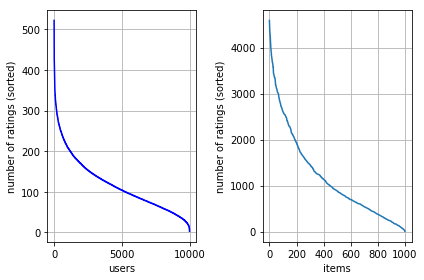

min # of items per user = 3, min # of users per item = 8.


In [5]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(data)
print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(987)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_users, :][: , valid_items]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_users, nz_items = valid_ratings.nonzero()
    
    # split the data
    for item in set(nz_items):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, item].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, item] = valid_ratings[residual, item]

        # add to test set
        test[selects, item] = valid_ratings[selects, item]

    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in validated data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [7]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    data, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (10000, 1000)
Total number of nonzero elements in original data:1176952
Total number of nonzero elements in validated data:1176952
Total number of nonzero elements in train data:1065354
Total number of nonzero elements in test data:111598


In [8]:
test

<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 111598 stored elements in LInked List format>

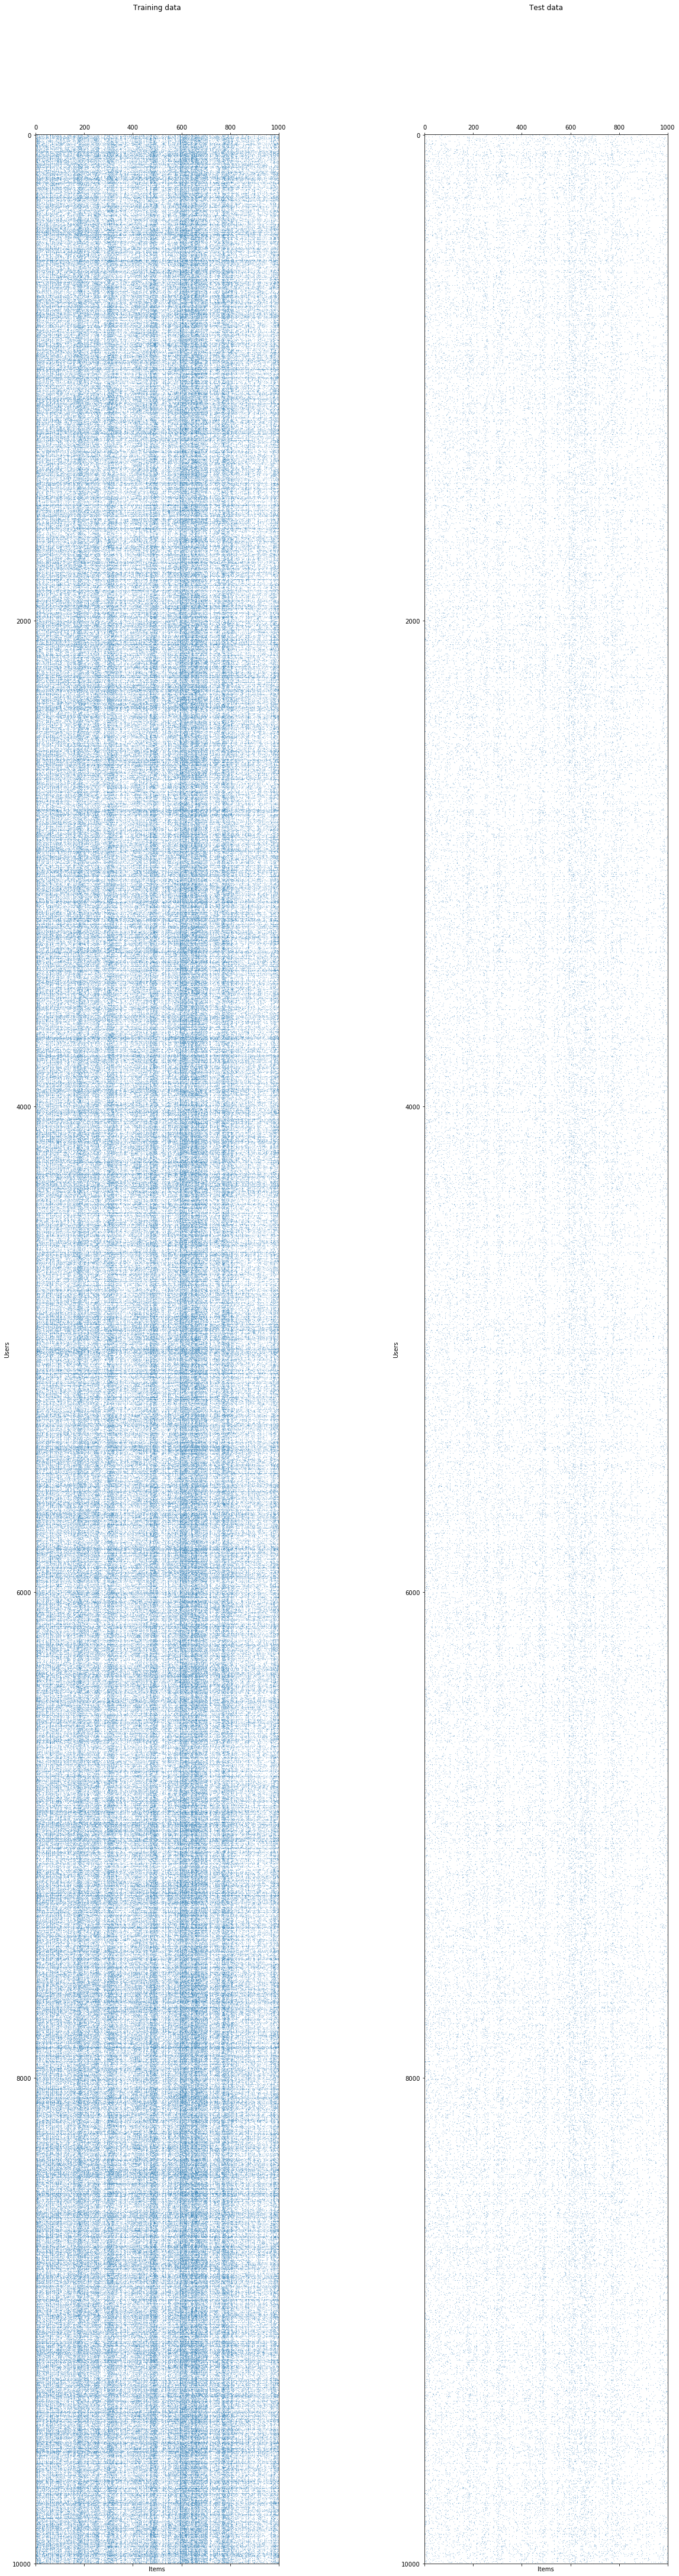

In [9]:
plot_train_test_data(train, test)

### Baseline predictions

In [10]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

#baseline_global_mean(train, test)

In [11]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_users, num_items = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[user_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[user_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

#baseline_user_mean(train, test)

In [12]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_users, num_items = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[:, item_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[:, item_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
#baseline_item_mean(train, test)

### Learn the Matrix Factorization using SGD

In [13]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_user, num_item = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=0)
    item_sum = train.sum(axis=0)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[0, ind] / item_nnz[ind]
        
    return user_features, item_features

In [14]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        user_info = user_features[:, row]
        item_info = item_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt((1.0 * mse) / (len(nz)))

In [58]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 3   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 1     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(987)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for n, d in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            user_info = user_features[:, n]
            item_info = item_features[:, d]
            
            err = train[n, d] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
    return user_features, item_features, errors

In [59]:
W, Z, errors = matrix_factorization_SGD(train, test)  

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1469694936961252.
RMSE on test data: 1.1584973538847394.


In [60]:
compute_error(test, W, Z, list(zip(*test.nonzero())))

1.1584973538847394

In [61]:
pred = W.T@Z

In [62]:
pred.shape

(10000, 1000)

### Learn the Matrix Factorization using Alternating Least Squares

In [113]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[user, items].T
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[users, item]
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [132]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 100   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.1
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(1042)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_users_per_item, nnz_items_per_user = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_user_itemindices, nz_item_userindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))
    
    return user_features, item_features, error_list

In [133]:
W, Z, error_l = ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.1544273511770788.
RMSE on training set: 1.0037254089635248.
RMSE on training set: 0.9673813847415259.
RMSE on training set: 0.9450151250909942.
RMSE on training set: 0.9303160616633503.
RMSE on training set: 0.9201401594070545.
RMSE on training set: 0.9127977954803734.
RMSE on training set: 0.907326722375636.
RMSE on training set: 0.9031447473316231.
RMSE on training set: 0.8998809451149083.
RMSE on training set: 0.8972889102895852.
RMSE on training set: 0.8951994958771525.
RMSE on training set: 0.8934934382514721.
RMSE on training set: 0.8920847043305656.
RMSE on training set: 0.8909099905470846.
RMSE on training set: 0.8899219050522355.
RMSE on training set: 0.8890844207249863.
RMSE on training set: 0.8883697652571394.
RMSE on training set: 0.8877562473664983.
RMSE on training set: 0.8872267119983942.
RMSE on training set: 0.8867674299504309.
RMSE on training set: 0.8863672931807577.
RMSE on training set: 0.8860172269812884.
RMSE on

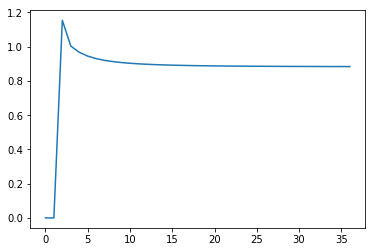

In [136]:
plt.plot(error_l)

In [141]:
compute_error(test, W, Z, list(zip(*test.nonzero())))

0.98476520675622792

In [ ]:
Best error = 0.98476520675622792

In [138]:
pred = W.T@Z

In [139]:
pred.shape

(10000, 1000)

### External library : Nimfa

In [43]:
import nimfa
from nimfa.utils.linalg import ceil

In [44]:
def initialize_matrices(V, rank, seed=None):
        """
        Return initialized basis and mixture matrix. Initialized matrices are of
        the same type as passed target matrix.
        """
        rank = rank
        p_c = int(ceil((1. / 5) * V.shape[1]))
        p_r = int(ceil((1. / 5) * V.shape[0]))
        prng = np.random.RandomState(seed)
        if sp.isspmatrix(V):
            W = sp.lil_matrix((V.shape[0], rank))
            H = sp.lil_matrix((rank, V.shape[1]))
        else:
            W = np.mat(np.zeros((V.shape[0], rank)))
            H = np.mat(np.zeros((rank, V.shape[1])))
        for i in range(rank):
            W[:, i] = V[:, prng.randint(low=0, high=V.shape[1], size=p_c)].mean(axis=1)
            H[i, :] = V[prng.randint(low=0, high=V.shape[0], size=p_r), :].mean(axis=0)
        # return sparse or dense initialization
        if sp.isspmatrix(V):
            return W.tocsr(), H.tocsr()
        else:
            return W, H

In [105]:
V = train.copy()
"""V = np.matrix(np.random.randint(0, 6, (20, 20), np.int))
print('Target:\n%s' % V)"""

rank_ = 100
W_, Z_ = initialize_matrices(V, rank_, seed=420)

lsnmf = nimfa.Lsnmf(V, seed=None, W=W_, H=Z_, max_iter=10, rank=rank_)
lsnmf_fit = lsnmf()

W_pred = lsnmf_fit.basis()
Z_pred = lsnmf_fit.coef()

In [106]:
ww = W_pred.T.todense()
zz = Z_pred.todense()

In [107]:
compute_error(test, np.array(ww), np.array(zz), list(zip(*test.nonzero())))

3.2710599423768945

In [112]:
zz.shape

(100, 1000)

### Creating submission

In [238]:
"""sub = pd.DataFrame(columns=['Id', 'Prediction'])
sub.to_csv("prediction.csv", index=False)

for i, row in enumerate(sub_ex.itertuples(False)):
    tmp1, tmp2 = row_col(row[0], reg=r)
    value = round(pred[tmp1-1, tmp2-1])
    
    sub = sub.append({'Id':'r'+str(tmp1)+'_c'+str(tmp2),'Prediction':value}, ignore_index=True)
    
    if i%1000 == 0:
        print(round(100*i/sub_ex.shape[0], 3), "% completed")
        sub.to_csv("prediction.csv", index=False, header=False, mode='a')
        sub = pd.DataFrame(columns=['Id', 'Prediction'])
        
print("100% completed")
sub.to_csv("prediction.csv", index=False, header=False, mode='a')
sub = pd.DataFrame(columns=['Id', 'Prediction'])"""
pass

In [140]:
import csv

def create_csv_submission(pred_nonzero, approx, name, round_=False):
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for row, col in pred_nonzero:
            ids = 'r' + str(row+1) + '_c' + str(col+1)
            
            if round_:
                value = round(approx[row, col])
            else:
                value = approx[row, col]
                
            writer.writerow({'Id':ids,'Prediction':value})
            
create_csv_submission(list(zip(*sub_ex.nonzero())), pred, 'potato.csv')